In [1]:
import os
import subprocess
import scipy
import re
import numpy as np
import matplotlib.pyplot as plt

## 1. Convert to mp4 files with using suggested bitrates

In [2]:
def convert_yuv_to_mp4(input_dir, output_dir):
    # Convert YUV files to yuv format for different bitrates and resolutions
    for i in range(len(resolutions)):
        yuv_file = os.path.join(input_dir, f"dancing.{resolutions[i][0]}x{resolutions[i][1]}.yuv")
        for j in range(len(bitrates[i])):
            bitrate = bitrates[i][j]
            output_file = os.path.join(output_dir, f"dancing_{resolutions[i][0]}x{resolutions[i][1]}_{bitrate}k.yuv")
            cmd = f"ffmpeg -s {resolutions[i][0]}x{resolutions[i][1]} -pix_fmt yuv420p -i {yuv_file} -b:v {bitrate}k -vcodec libx264 -pix_fmt yuv420p {output_file}"
            os.system(cmd)

## 2. Convert compressed mp4 files back to yuv files

In [3]:
def convert_mp4_to_yuv(input_dir, output_dir):
    # Convert mp4 files to yuv format for different bitrates and resolutions
    for i in range(len(resolutions)):
        for j in range(len(bitrates[i])):
            bitrate = bitrates[i][j]
            mp4_file = os.path.join(input_dir, f"dancing_{resolutions[i][0]}x{resolutions[i][1]}_{bitrate}k.mp4")
            output_file = os.path.join(output_dir, f"dancing_{resolutions[i][0]}x{resolutions[i][1]}_{bitrate}k.yuv")
            cmd = f'ffmpeg -i {mp4_file} -pix_fmt yuv420p -f rawvideo {output_file}'
            os.system(cmd)

## 3. Upsample yuv files to 720p

In [6]:
def upsample_resolutions(input_dir, output_dir):
    for i in range(len(resolutions)):
        for j in range(len(bitrates[i])):
            bitrate = bitrates[i][j]
            yuv_file = os.path.join(input_dir, f"dancing_{resolutions[i][0]}x{resolutions[i][1]}_{bitrate}k.yuv")
            output_file = os.path.join(output_dir, f"dancing_1280x548_from_{resolutions[i][0]}x{resolutions[i][1]}_{bitrate}k.yuv")
            cmd = f'ffmpeg -s {resolutions[i][0]}x{resolutions[i][1]} -pix_fmt yuv420p -i {yuv_file} -vf "scale=1280:548:flags=bicubic" -pix_fmt yuv420p {output_file}'
            os.system(cmd)

## 4. Calculate PSNR value

In [7]:
def calculate_psnr(compressed_path, original_path='../data/dancing_org.1280x548.yuv'):
    cmd = f'ffmpeg -s:v 1280x548 -i {original_path} -s:v 1280x548 -i {compressed_path} -lavfi psnr -f null -'
    psnr_output = subprocess.check_output(cmd.split(), stderr=subprocess.STDOUT).decode()
    psnr_line = psnr_output.split('\n')[-2]
    match = re.search(r"average:([\d.]+)", psnr_line)
    psnr = 0
    if match:
        psnr = float(match.group(1))
    return psnr

def get_psnr_value(input_dir):
    res = {}
    for i in range(len(resolutions)):
        k1 = str(resolutions[i][0]) + "_psnr"
        k2 = str(resolutions[i][0]) + "_bitrate"
        res[k1] = []
        res[k2] = []
        
        for j in range(len(bitrates[i])):
            bitrate = bitrates[i][j]
            yuv_file = os.path.join(input_dir, f"dancing_1280x548_from_{resolutions[i][0]}x{resolutions[i][1]}_{bitrate}k.yuv")
            pnsr = calculate_psnr(yuv_file)
            
            res[k1].append(pnsr)
            res[k2].append(bitrate)
    return res

## 5. Draw RD Curves

In [8]:
def draw_rd_curves(resData):
    # Plot RD curves
    fig, ax = plt.subplots()
    ax.plot(resData['1280_bitrate'], resData['1280_psnr'], 'o-', label='720p')
    ax.plot(resData['640_bitrate'], resData['640_psnr'], 'o-', label='640p')
    ax.plot(resData['320_bitrate'], resData['320_psnr'], 'o-', label='320p')

    # Set plot title and labels
    ax.set_title('Rate-Distortion curves')
    ax.set_xlabel('Bitrate (Kbps)')
    ax.set_ylabel('PSNR')

    # Set plot legend
    ax.legend()

    # Display plot
    plt.show()

In [16]:
def draw_rd_curves_with_interact_point(resData):
    # Plot RD curves
    fig, ax = plt.subplots()
    ax.plot(resData['1280_bitrate'], resData['1280_psnr'], 'o-', label='720p')
    ax.plot(resData['640_bitrate'], resData['640_psnr'], 'o-', label='640p')
    ax.plot(resData['320_bitrate'], resData['320_psnr'], 'o-', label='320p')
    
    # Plot intersection point
    plt.plot(x1, y1, marker='o', markersize=10, color='black')
    plt.plot(x2, y2, marker='o', markersize=10, color='black')

    # Set plot title and labels
    ax.set_title('Rate-Distortion curves')
    ax.set_xlabel('Bitrate (Kbps)')
    ax.set_ylabel('PSNR')

    # Set plot legend
    ax.legend()

    # Display plot
    plt.show()

In [6]:
def find_intersection(x1, y1, x2, y2, x3, y3, x4, y4):
    # Calculate slopes and y-intercepts of the two lines
    m1 = (y2-y1)/(x2-x1)
    b1 = y1 - m1*x1
    m2 = (y4-y3)/(x4-x3)
    b2 = y3 - m2*x3
    
    # Calculate intersection point
    x = (b2-b1)/(m1-m2)
    y = m1*x + b1
    
    # Check if intersection point lies within both line segments
    if x1 <= x <= x2 and y1 <= y <= y2 and x3 <= x <= x4 and y3 <= y <= y4:
        return (x, y)
    else:
        return None

## Main

In [11]:
resolutions = [(1280, 548), (640, 274), (320, 138)]
bitrates = [
    [512, 1024, 2048, 3072],
    [96, 128, 256, 384, 512, 1024, 2048],
    [64, 96, 128, 256, 512, 1024]
]

In [12]:
# convert_yuv_to_mp4("./data/", "./output/")

In [13]:
# convert_mp4_to_yuv("./output/", "yuv/")

In [14]:
# upsample_resolutions("../yuv/", "../upsample/")

{'1280_psnr': [35.865423, 40.455529, 44.293714, 46.968191], '1280_bitrate': [512, 1024, 2048, 3072], '640_psnr': [29.491678, 31.13402, 35.094403, 37.077579, 38.399056, 41.170151, 43.120089], '640_bitrate': [96, 128, 256, 384, 512, 1024, 2048], '320_psnr': [28.899828, 29.898329, 30.430972, 31.291129, 31.688049, 31.857165], '320_bitrate': [64, 96, 128, 256, 512, 1024]}


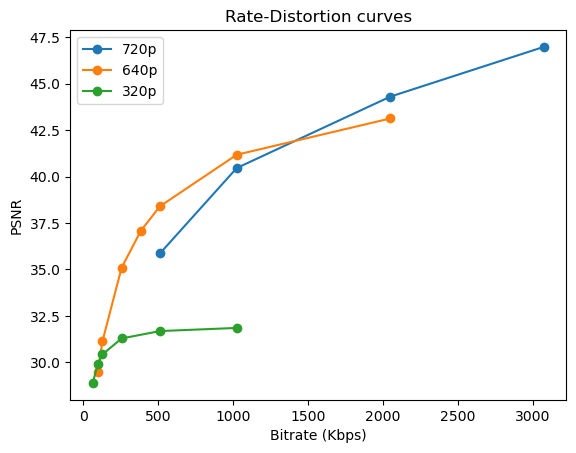

In [15]:
pnsr_data = get_psnr_value('../upsample/')
print(pnsr_data)

draw_rd_curves(pnsr_data)

In [11]:
import random

data = {'1280_psnr': [35.865423, 40.455529, 44.293714, 46.968191],
        '1280_bitrate': [512, 1024, 2048, 3072],
        '640_psnr': [29.491678, 31.13402, 35.094403, 37.077579, 38.399056, 41.170151, 43.120089],
        '640_bitrate': [96, 128, 256, 384, 512, 1024, 2048],
        '320_psnr': [28.899828, 29.898329, 30.430972, 31.291129, 31.688049, 31.857165],
        '320_bitrate': [64, 96, 128, 256, 512, 1024]}

for key in data.keys():
    if 'psnr' in key:
        values = data[key]
        new_values = [v + random.uniform(-0.1, 0.1) for v in values]
        data[key] = new_values

print(data)

pnsr_data = data

{'1280_psnr': [35.924905564957854, 40.38907967643092, 44.36529253326745, 46.948355180367024], '1280_bitrate': [512, 1024, 2048, 3072], '640_psnr': [29.483452102574656, 31.0517201261945, 35.104950742473235, 37.15566073300332, 38.405906864479824, 41.2183540848591, 43.07429226394841], '640_bitrate': [96, 128, 256, 384, 512, 1024, 2048], '320_psnr': [28.898103202666128, 29.80385897903432, 30.42662576010218, 31.222321567515372, 31.621309322023098, 31.870785336286055], '320_bitrate': [64, 96, 128, 256, 512, 1024]}


### Calculate the interact point

In [12]:
x1, y1 = find_intersection(pnsr_data["1280_bitrate"][1], pnsr_data["1280_psnr"][1], 
                         pnsr_data["1280_bitrate"][2], pnsr_data["1280_psnr"][2], 
                         pnsr_data["640_bitrate"][5], pnsr_data["640_psnr"][5], 
                         pnsr_data["640_bitrate"][6], pnsr_data["640_psnr"][6])
print(x1, y1)

x2, y2 = find_intersection(pnsr_data["320_bitrate"][1], pnsr_data["320_psnr"][1], 
                         pnsr_data["320_bitrate"][2], pnsr_data["320_psnr"][2], 
                         pnsr_data["640_bitrate"][0], pnsr_data["640_psnr"][0], 
                         pnsr_data["640_bitrate"][1], pnsr_data["640_psnr"][1])
print(x2, y2)

1424.5032947583488 41.94424212743046
106.84400483603335 30.01489916608497


In [18]:
ave_bitrate = (x1 + x2) / 2
ave_psnr = (y1 + y2) / 2

print(ave_bitrate, ave_psnr)

765.673649797191 35.979570646757715


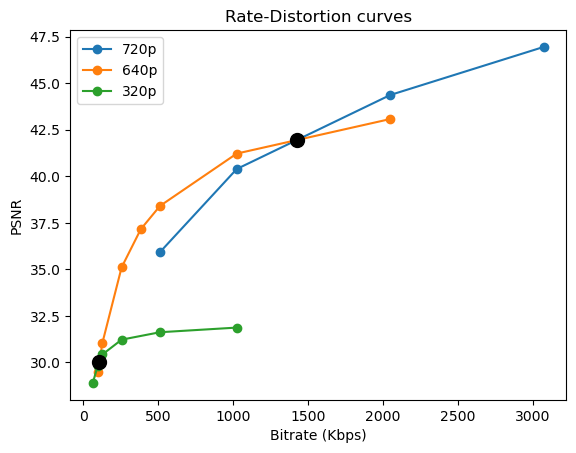

In [17]:
draw_rd_curves_with_interact_point(pnsr_data)

In [19]:
def get_value(x1, y1, x2, y2, bitrate):
    m1 = (y2-y1)/(x2-x1)
    b1 = y1 - m1*x1
    
    return m1 * bitrate + b1

### 200-500kbps in H.264/DASH

In [29]:
get_value(pnsr_data["320_bitrate"][3], pnsr_data["320_psnr"][3], pnsr_data["320_bitrate"][4], pnsr_data["320_psnr"][4], 500)

31.669443375

### 400-1200kbps H.264/DASH

In [30]:
get_value(pnsr_data["640_bitrate"][5], pnsr_data["640_psnr"][5], pnsr_data["640_bitrate"][6], pnsr_data["640_psnr"][6], 1200)

41.505296593749996

In [20]:
get_value(pnsr_data["640_bitrate"][4], pnsr_data["640_psnr"][4], pnsr_data["640_bitrate"][5], pnsr_data["640_psnr"][5], 759.63)

39.73930259150391

### 1500-4000kbps H2.64/DASH

In [ ]:
get_value(pnsr_data["640_bitrate"][5], pnsr_data["640_psnr"][5], pnsr_data["640_bitrate"][6], pnsr_data["640_psnr"][6], 1200)